# Omega Aragonite Escape Velocity Regional Comparison over 50-year Timescales

# 10 year Moving Average every 1 year

In [1]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from xhistogram.xarray import histogram
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## Surface k11 RCP45 Ensemble Average

In [4]:
# k11 Omega Arag for ensemble average (preprocessed)
directory = '~/chazbpei2020/data/processed/Omega_Arag/RCP45/'
filename = 'omega_arag_k11_ensAvg_2006_2100.nc'
oa_path = directory+filename
ds = xr.open_dataset(oa_path).rename({'XT_OCEAN': 'xt_ocean',
                                     'YT_OCEAN': 'yt_ocean',
                                     'TIME': 'time',
                                     'OMEGA_ARAG': 'omega_arag'})

---

## Decadal Moving Average Omega Arag

In [5]:
# Calculate the time-mean Omega Arag throughout the simulation
da_oa_annual = ds.omega_arag.groupby('time.year').mean(dim='time', skipna=True).squeeze()

startyear = 2006
endyear = 2100
interval = 10  # take mean over interval years
span = interval//2
offset=4

da_oa_mean = da_oa_annual.copy() # annual averages from 2006-2100

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Calculate Escape Vectors

In [6]:
# Definte projection transformations and coordiantes
crs = ccrs.Robinson(central_longitude=180)
src=ccrs.PlateCarree()
lon = ds.xt_ocean.data
lat = ds.yt_ocean.data


# Create levels array to isolate undersaturation threshold
clevs=[1]

# Create list of colors and legend for plots
colors = ['magenta','darkviolet','mediumblue','dodgerblue','turquoise',
          'limegreen','gold','darkorange','red','maroon']

num_contours = len(da_oa_mean)
num_colors = len(colors)
year=startyear+offset  # start in 2010
legend_years = []
c = 0
for i in range(0, num_contours, interval):
    element = Patch(facecolor=colors[c], label=str(year))
    legend_years.append(element)
    year+=interval
    c+=1

## Plot undersaturation borders

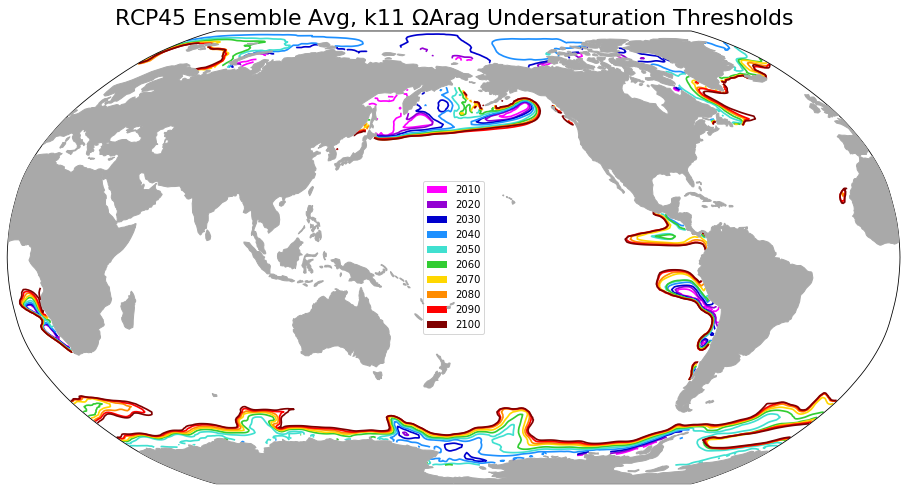

In [7]:
# Plot Velocities at undersaturation border for every 2 years
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})
    
# Plot contours for each decade
c = 0
for i in range(offset, num_contours, interval):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[c],linewidths=1.7,transform=src)
    c += 1
    
ax.legend(handles=legend_years, loc='center')
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.set_title('RCP45 Ensemble Avg, k11 $\Omega$Arag Undersaturation Thresholds',
             fontsize=22)
ax.set_global()

fig.savefig('./oa_escvel_figs/RCP45/oa_k11_esc_contours')

## Get points along contours

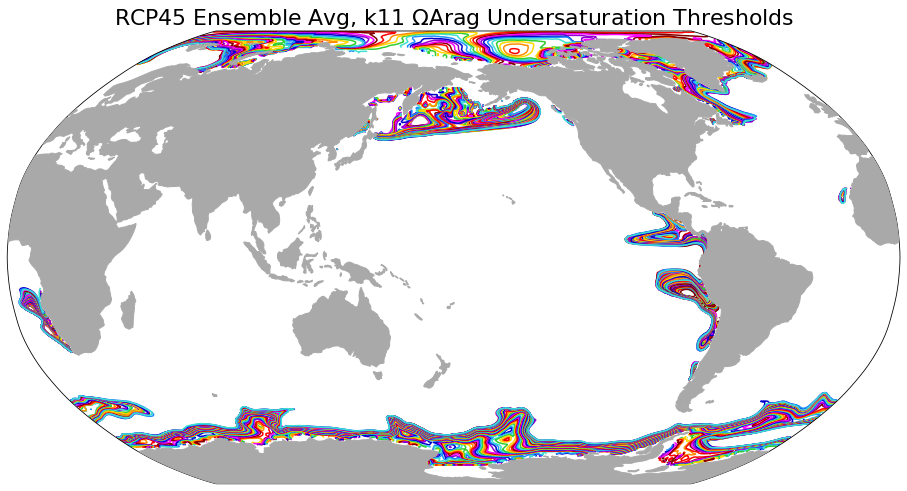

In [8]:
# Calculate Velocities at undersaturation border for every 2 years
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})
    
# Extract points from contour line segments for each decade
list_xpoints = []  # list contianing lists of x points for each decade
list_ypoints = []  # list contianing lists of y points for each decade
for i in range(0, num_contours):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[i%num_colors],transform=src)
    
    segments = cs.allsegs[0]
    num_segs = len(segments)
    
    xpoints = []  # to track multiple paths within each decade
    ypoints = []
    for j in range(num_segs):
        x = segments[j][:,0].tolist()  # convert to list to be easily concatenated
        y = segments[j][:,1].tolist()
        for p in x:
            xpoints.append(p)
        for p in y:
            ypoints.append(p)
    list_xpoints.append(xpoints)  # add list of x points for each decade
    list_ypoints.append(ypoints)  # add list of y points for each decade

ax.set_title('RCP45 Ensemble Avg, k11 $\Omega$Arag Undersaturation Thresholds',
             fontsize=22)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.set_global()

## Calculations

In [9]:
# Round all values to nearest 0.5 (to be easily indexed)
# Create adjusted list to use later for indexing
list_xpoints_idx = []
list_ypoints_idx = []
for i in range(num_contours):  # list of lists
    xpoints = list_xpoints[i]  # individual list of xpoints
    ypoints = list_ypoints[i]  # individual list of ypoints
    num_points = len(xpoints)
    for p in range(num_points):
        xpoints[p] = round_half(xpoints[p])
        ypoints[p] = round_half(ypoints[p])
    xpoints = (np.array(xpoints)-0.5).tolist()
    ypoints = (np.array(ypoints)+89.5).tolist()
    
    list_xpoints_idx.append(xpoints)
    list_ypoints_idx.append(ypoints)

In [10]:
# For each contour, compute the minimum distance to the contour at
# the end of the interval

# Create parallel arrays of list to hold lists of directions and vectors for each decade
list_vector_dx = []  # change in x
list_vector_dy = []  # change in y
list_vector_magnitude = []  # distance to nearest points

for i in range(0, num_contours-interval):
    vector_dx = []  # change in x for decade
    vector_dy = []  # change in y for decade
    vector_magnitude = []  # vector magnitude for decade
    xpoints = list_xpoints[i]  # x coords for decade
    ypoints = list_ypoints[i]  # y coords for decade
    # For each point, find min dist and closest point on contour 
    # at the end of the time interval (one decade later)
    num_points = len(xpoints)
    for p in range(num_points):
        xp = xpoints[p] # x value along contour
        yp = ypoints[p] # y value along contour
        x,y,dx,dy,mindist = min_dist(xp,yp,
                                     list_xpoints[i+interval],
                                     list_ypoints[i+interval],
                                    da_oa_mean[i].data)

        vector_dx.append(dx/1000)  # in km
        vector_dy.append(dy/1000)
        vector_magnitude.append(mindist/1000)  # dist magnitude
    
    list_vector_dx.append(vector_dx)
    list_vector_dy.append(vector_dy)
    list_vector_magnitude.append(vector_magnitude)

In [11]:
# Reformat data to be Mappable
nx = len(lon)
ny = len(lat)
da_esc_dx = []  # escape dx for each year
da_esc_dy = []  # escape dy for each year
da_esc_dist = []  # escape distances for each year

# For each year
for i in range(0,num_contours-interval):
    # Create empty arrays and initialize all values to np.nan
    da_dx = np.zeros(shape=(nx,ny))
    da_dx[:,:] = np.nan
    da_dy = np.zeros(shape=(nx,ny))
    da_dy[:,:] = np.nan
    da_dist = np.zeros(shape=(nx,ny))
    da_dist[:,:] = np.nan
    
    # Iterate through points in array of contour point indices
    x_idx = list_xpoints_idx[i]
    y_idx = list_ypoints_idx[i]
    dx_vals = list_vector_dx[i]
    dy_vals = list_vector_dy[i]
    dist_vals = list_vector_magnitude[i]
    # For each contour point in the decade, save the escape vector
    # magnitude and direction in parallel DataArrays
    num_points = len(x_idx)
    for p in range(num_points):
        xi = int(x_idx[p])
        yi = int(y_idx[p])
        da_dx[xi,yi] = dx_vals[p]
        da_dy[xi,yi] = dy_vals[p]
        da_dist[xi,yi] = dist_vals[p]
    
    # Save out the vector (directionality and magnitude) fields as maps 
    # for each year
    da_dx = xr.DataArray(da_dx, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dx = da_dx.where(da_dx < np.inf)
    da_esc_dx.append(da_dx)
    da_dy = xr.DataArray(da_dy, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dy = da_dy.where(da_dy < np.inf)
    da_esc_dy.append(da_dy)
    da_dist = xr.DataArray(da_dist, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dist = da_dist.where(da_dist < np.inf)
    da_esc_dist.append(da_dist)

## Plot Escape Vectors

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


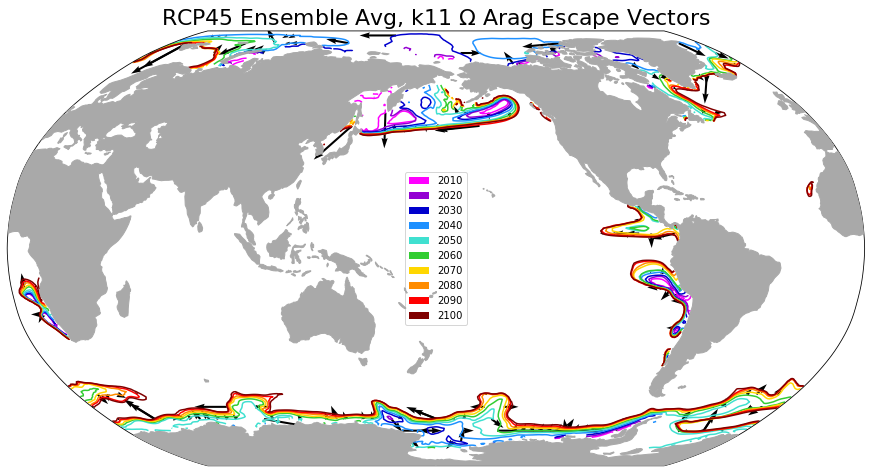

In [12]:
# Map escape vectors for all timestamps
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

# Create meshgrid for arrow plotting
X,Y = np.meshgrid(np.arange(360), np.arange(-90,90))
X = X+0.5
Y = Y+0.5
n=5

# Plot Omega Arag undersaturation contours for each decade
c=0
vel_data_range = num_contours-interval
# From 2010
for i in range(offset, vel_data_range, interval):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[c%num_colors],transform=src)
    c+=1
    
    # Plot escape vectors
    U = da_esc_dx[i].data
    V = da_esc_dy[i].data
    ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n], transform=src)

# Plot final decade contour
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors=colors[c],transform=src)
ax.legend(handles=legend_years, loc='center')
ax.set_title('RCP45 Ensemble Avg, k11 $\Omega$ Arag Escape Vectors',
             fontsize=22)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.set_global()

fig.savefig('./oa_escvel_figs/RCP45/oa_k11_esc_vectors')

---

# Calculate Escape Velocity

In [13]:
# Calculate escape velocity and create DataArray
year=startyear
da_esc_vel = []
vel_data_range = num_contours-interval
for i in range(vel_data_range):
    da_vel = (da_esc_dist[i]).copy().rename('Escape Velocity - '+str(year))
    da_esc_vel.append(da_vel)
    year+=1

# Escape Velocity with Corresponding Dot Sizes

In [14]:
# Transpose indices to match coordinates
list_xcoords = []
list_ycoords = []
list_escvel = []
# From years 2010 to 2090
for i in range(0,vel_data_range):
    xpoints = np.array(list_xpoints_idx[i])+0.5
    ypoints = np.array(list_ypoints_idx[i])-89.5
    escvel = np.array(list_vector_magnitude[i])*0.2
    list_xcoords.append(xpoints)
    list_ycoords.append(ypoints)
    list_escvel.append(escvel)

## Global and Regional Plots

## Global

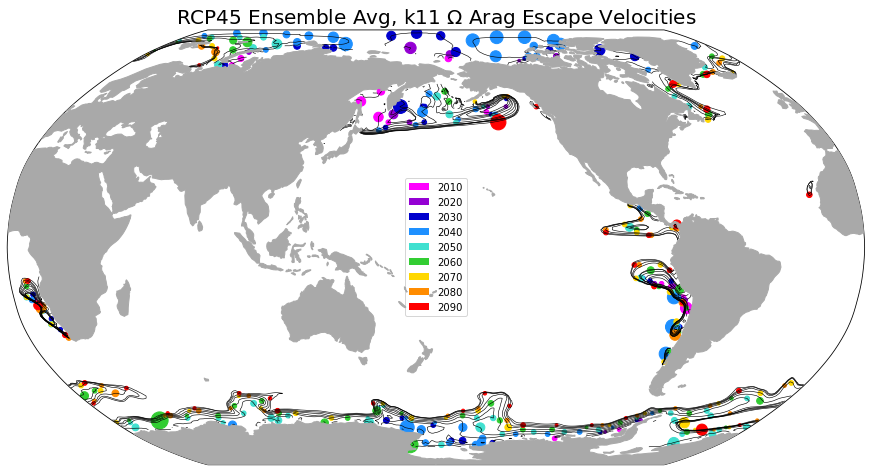

In [15]:
# Map escape velocity magnitudes for each decade
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

n = 20  # step size when iterating
lwidth = 0.6  # line width

# Decadal contours up to interval before end of simulation
c=0
### fix this
for i in range(offset, vel_data_range, interval):
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)
    
    # Plot dots with escape velocity magnitude
    ax.scatter(list_xcoords[i][::n], list_ycoords[i][::n],
               s=list_escvel[i][::n],
               color=colors[c],transform=src)
    c+=1
    
# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)

ax.legend(handles=legend_years[:-1], loc='center')
ax.set_title('RCP45 Ensemble Avg, k11 $\Omega$ Arag Escape Velocities',
             fontsize=20)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.set_global()
fig.savefig('./oa_escvel_figs/RCP45/oa_k11_esc_dots')

## Central and South American Coast

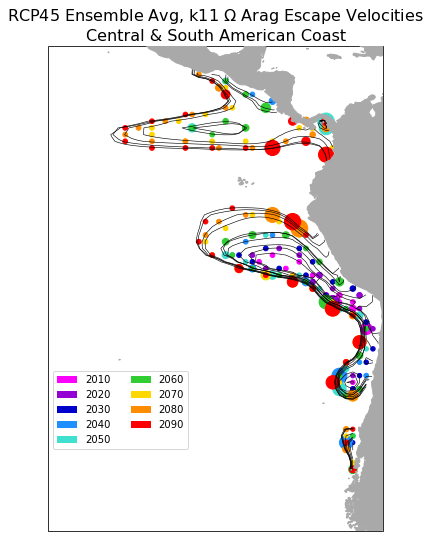

In [16]:
# Map escape velocity magnitudes Central and South America
fig, ax = plt.subplots(figsize=[6,9],
                               subplot_kw={'projection':src})

n = 5  # step size when iterating

# Decadal contours up to interval before end of simulation
c=0
for i in range(offset, vel_data_range, interval):
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)
    
    # Plot dots with escape velocity magnitude
    ax.scatter(list_xcoords[i][::n], list_ycoords[i][::n],
               s=list_escvel[i][::n],
               color=colors[c],transform=src)
    c+=1
    
# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)

ax.legend(handles=legend_years[:-1], loc='center left',bbox_to_anchor=(0,0.25),ncol=2)
ax.set_title('RCP45 Ensemble Avg, k11 $\Omega$ Arag Escape Velocities\nCentral & South American Coast',
             fontsize=16)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
extents = [-120,-70,-50,18]  # [x0,x1,y0,y1]
ax.set_extent(extents)

fig.savefig('./oa_escvel_figs/RCP45/oa_k11_esc_dots_america')

## African Coast

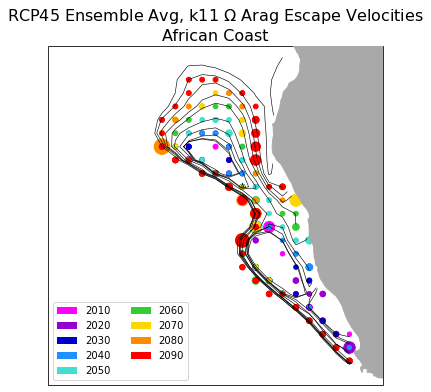

In [17]:
# Map escape velocity magnitudes for African Coast
fig, ax = plt.subplots(figsize=[6,9],
                               subplot_kw={'projection':src})

n = 1  # step size when iterating

# Decadal contours up to interval before end of simulation
c=0
for i in range(offset, vel_data_range, interval):
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)
    
    # Plot dots with escape velocity magnitude
    ax.scatter(list_xcoords[i][::n], list_ycoords[i][::n],
               s=list_escvel[i][::n],
               color=colors[c],transform=src)
    c+=1
    
# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)

ax.legend(handles=legend_years[:-1], loc='lower left',ncol=2)
ax.set_title('RCP45 Ensemble Avg, k11 $\Omega$ Arag Escape Velocities\nAfrican Coast',
             fontsize=16)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
extents = [-5,20,-35,-10]  # [x0,x1,y0,y1]
ax.set_extent(extents)
fig.savefig('./oa_escvel_figs/RCP45/oa_k11_esc_dots_africa')

## Northern Pacific Ocean

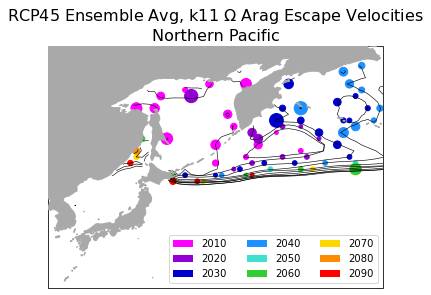

In [18]:
# Map escape velocity magnitudes for Northern Pacific
fig, ax = plt.subplots(figsize=[6,9],
                               subplot_kw={'projection':src})

n = 5  # step size when iterating

# Decadal contours up to interval before end of simulation
c=0
for i in range(offset, vel_data_range, interval):
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)
    
    # Plot dots with escape velocity magnitude
    ax.scatter(list_xcoords[i][::n], list_ycoords[i][::n],
               s=list_escvel[i][::n],
               color=colors[c],transform=src)
    c+=1
    
# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)

ax.legend(handles=legend_years[:-1], loc='lower right',ncol=3)
ax.set_title('RCP45 Ensemble Avg, k11 $\Omega$ Arag Escape Velocities\nNorthern Pacific',
             fontsize=16)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
extents = [125,180,25,62]  # [x0,x1,y0,y1]
ax.set_extent(extents)
fig.savefig('./oa_escvel_figs/RCP45/oa_k11_esc_dots_northpacific')

___

## Differentiate Regions

In [19]:
da_escvel_arctic = []  # Arctic ocean
da_escvel_equ = []  # Equatorial region
da_escvel_south = []  # Southern ocean
for i in range(vel_data_range):
    da_escvel_arctic.append(da_esc_vel[i].loc[35:80,:].copy())  # don't use 80N and above
    da_escvel_equ.append(da_esc_vel[i].loc[-40:35,:].copy())
    da_escvel_south.append(da_esc_vel[i].loc[-90:-40,:].copy())

In [20]:
# Define bin range and interval size
xlim = 601  # use (top value)+1 to ease indexing
vstep = 100
# vlevels = [0, 50, 100, 250, 500, 1000]
vlevels = np.arange(0, xlim, vstep)
vbins = np.array(vlevels)

In [21]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## Differentiate Historic, Contemporary, Future Time Periods *** Organize Timescales

In [22]:
# Calculate average Escape Velocity distributions for each region
# during each time period
contemp = 50
future = 100
end = vel_data_range

# da_escvel_arctic
arctic_historic_mean = hist_mean(da_escvel_arctic, vlevels, 0, contemp, 'arctic_historic')
arctic_contemp_mean = hist_mean(da_escvel_arctic, vlevels, contemp, future, 'arctic_contemp')
arctic_future_mean = hist_mean(da_escvel_arctic, vlevels, future, end, 'arctic_future')

# da_escvel_equ
equ_historic_mean = hist_mean(da_escvel_equ, vlevels, 0, contemp, 'equ_historic')
equ_contemp_mean = hist_mean(da_escvel_equ, vlevels, contemp, future, 'equ_contemp')
equ_future_mean = hist_mean(da_escvel_equ, vlevels, future, end, 'equ_future')

# da_escvel_south
south_historic_mean = hist_mean(da_escvel_south, vlevels, 0, contemp, 'south_historic')
south_contemp_mean = hist_mean(da_escvel_south, vlevels, contemp, future, 'south_contemp')
south_future_mean = hist_mean(da_escvel_south, vlevels, future, end, 'south_future')

# da_esc_vel
global_historic_mean = hist_mean(da_esc_vel, vlevels, 0, contemp, 'global_historic')
global_contemp_mean = hist_mean(da_esc_vel, vlevels, contemp, future, 'global_contemp')
global_future_mean = hist_mean(da_esc_vel, vlevels, future, end, 'global_future')

IndexError: list index out of range

## Velocity Distribution Plots

In [ ]:
# Create discreet color map and legend
clrs = mpl.cm.viridis(np.linspace(0,1,13))

num_clrs = len(clrs)
year=startyear+interval  # start in 1960
legend_yrs = []
c = 0
for i in range(offset, vel_data_range, interval):
    element = Patch(facecolor=clrs[c], label=str(year))
    legend_yrs.append(element)
    year+=interval
    c+=1

In [ ]:
# Create Histograms for escape velocity distribution at each timestep
fig, ax = plt.subplots(figsize=[10,8])

year = 1960
t = year-1955
c=0
for i in range(offset, vel_data_range, interval):
#     cleaned_escvel = [x for x in list_escvel[i] if np.isfinite(x)]
#     cleaned_escvel = xr.DataArray(cleaned_escvel).rename('filler')
#     sns.distplot(cleaned_escvel, ax=ax, bins=vbins, color=colors[c], 
#                  hist=True,label="Compact")   # needs a color name

#     h = hist_mean(da_esc_vel, vlevels, i, i+1)

    h = histogram(da_esc_vel[i], bins=[vbins])
    h = h / h.sum();
    h.plot(ax=ax,color=clrs[c])
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_xlim(0,xlim)
    ax.set_xticks(vlevels[:-1])
    ax.set_ylabel('Proportion',fontsize=16)
    ax.set_ylim(0,0.6)
    ax.legend(handles=legend_yrs, loc='upper right',ncol=3)

    ax.label_outer()
    year+=10
    t+=10
    c+=1

fig.suptitle('RCP45 Ensemble Avg, k11 $\Omega$ Arag Escape Velocity Distributions',
            fontsize=20)
fig.savefig("./oa_escvel_stats/oa_k11_escvel_distrib_1plot")

In [ ]:
# Define legend and colormap
colorcmp = ['plum','darkviolet','indigo',
            'moccasin','darkorange','orangered',
            'lawngreen','limegreen','green',
           'lightskyblue','dodgerblue','blue']
regions = ['Arctic (Historical)','Arctic (Contemporary)','Arctic (Future)',
           'Equatorial (Historical)','Equatorial (Contemporary)','Equatorial (Future)',
          'Southern (Historical)','Southern (Contemporary)','Southern (Future)',
          'Global (Historical)','Global (Contemporary)','Global (Future)']
legend_regions = []
num_cmap = len(colorcmp)
for i in range(num_cmap):
    element = Patch(facecolor=colorcmp[i], label=regions[i])
    legend_regions.append(element)

In [ ]:
# Create Histograms for Different Regions' Escape Velocities
nrows=1
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,6], 
                        sharex=True,sharey=True)

num_bins = len(vlevels)-1
d = scipy.zeros(num_bins)
xs = np.arange(0,xlim-1,vstep)

# Arctic
ax = axs[0]
ys = arctic_historic_mean
ys.plot(ax=axs[0],color=colorcmp[0])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[0])
ys = arctic_contemp_mean
ys.plot(ax=axs[0],color=colorcmp[1])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[1])
ys = arctic_future_mean
ys.plot(ax=ax,color=colorcmp[2])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[2])
ax.set_title('Arctic Ocean',fontsize=16)

# Equatorial
ax = axs[1]
ys = equ_historic_mean
ys.plot(ax=ax,color=colorcmp[3])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[3])
ys = equ_contemp_mean
ys.plot(ax=ax,color=colorcmp[4])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[4])
ys = equ_future_mean
ys.plot(ax=ax,color=colorcmp[5])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[5])
ax.set_title('Equatorial Ocean',fontsize=16)

# Southern
ax = axs[2]
ys = south_historic_mean
ys.plot(ax=ax,color=colorcmp[6])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[6])
ys = south_contemp_mean
ys.plot(ax=ax,color=colorcmp[7])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[7])
ys = south_future_mean
ys.plot(ax=ax,color=colorcmp[8])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[8])
ax.set_title('Southern Ocean',fontsize=16)

i = 0
for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion',fontsize=16)
    ax.set_ylim(0,0.6)
    ax.label_outer()
    ax.legend(handles=legend_regions[i:i+3], loc='upper right')
    i+=3
    
    fig.suptitle('$\Omega$ Arag Regional Escape Velocity Distribution',
                fontsize=25)

In [ ]:
# Create Histograms for Different Regions' Escape Velocities
nrows=1
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,6], 
                        sharex=True,sharey=True)
# Arctic Ocean
ax = axs[0]
arctic_historic_mean.plot(ax=ax,color=colorcmp[0])
arctic_contemp_mean.plot(ax=ax,color=colorcmp[1])
arctic_future_mean.plot(ax=ax,color=colorcmp[2])
ax.set_title('Arctic Ocean',fontsize=16)

# Equatorial Ocean
ax = axs[1]
equ_historic_mean.plot(ax=ax,color=colorcmp[3])
equ_contemp_mean.plot(ax=ax,color=colorcmp[4])
equ_future_mean.plot(ax=ax,color=colorcmp[5])
ax.set_title('Equatorial Ocean',fontsize=16)

# Southern Ocean
ax = axs[2]
south_historic_mean.plot(ax=ax,color=colorcmp[6])
south_contemp_mean.plot(ax=ax,color=colorcmp[7])
south_future_mean.plot(ax=ax,color=colorcmp[8])
ax.set_title('Southern Ocean',fontsize=16)

i=0
for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_ylim(0,0.6)
    ax.label_outer()
    ax.legend(handles=legend_regions[i:i+3], loc='upper right')
    i+=3
    
fig.suptitle('$\Omega$ Arag Regional Escape Velocity Distribution',
                fontsize=25)

In [ ]:
# Create Histograms for Different Regions' Escape Velocities
nrows=3
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12,10], 
                        sharex=True,sharey=True)
# Arctic
ax = axs[0]
arctic_historic_mean.plot(ax=ax,color=colorcmp[0])
arctic_contemp_mean.plot(ax=ax,color=colorcmp[1])
arctic_future_mean.plot(ax=ax,color=colorcmp[2])
ax.set_title('Arctic Escape Velocities',fontsize=16)

# Equatorial
ax = axs[1]
equ_historic_mean.plot(ax=ax,color=colorcmp[3])
equ_contemp_mean.plot(ax=ax,color=colorcmp[4])
equ_future_mean.plot(ax=ax,color=colorcmp[5])
ax.set_title('Equatorial Escape Velocities',fontsize=16)

# Southern
ax = axs[2]
south_historic_mean.plot(ax=ax,color=colorcmp[6])
south_contemp_mean.plot(ax=ax,color=colorcmp[7])
south_future_mean.plot(ax=ax,color=colorcmp[8])
ax.set_title('Southern Escape Velocities',fontsize=16)

i=0
for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion',fontsize=14)
    ax.set_ylim(0,0.6)
    ax.label_outer()
    ax.legend(handles=legend_regions[i:i+3], loc='upper right')
    i+=3
    
fig.suptitle('$\Omega$ Arag Regional Escape Velocity Distributions',
                fontsize=22)

In [ ]:
# Create Histogram for Different Regions' Escape Velocities (single plot)
fig, ax = plt.subplots(figsize=[10,6], 
                        sharex=True,sharey=True)

arctic_historic_mean.plot(ax=ax,color=colorcmp[0])
arctic_contemp_mean.plot(ax=ax,color=colorcmp[1])
arctic_future_mean.plot(ax=ax,color=colorcmp[2])

equ_historic_mean.plot(ax=ax,color=colorcmp[3])
equ_contemp_mean.plot(ax=ax,color=colorcmp[4])
equ_future_mean.plot(ax=ax,color=colorcmp[5])

south_historic_mean.plot(ax=ax,color=colorcmp[6])
south_contemp_mean.plot(ax=ax,color=colorcmp[7])
south_future_mean.plot(ax=ax,color=colorcmp[8])

# global_historic_mean.plot(ax=ax,color=colorcmp[9])
# global_contemp_mean.plot(ax=ax,color=colorcmp[10])
# global_future_mean.plot(ax=ax,color=colorcmp[11])

ax.set_title('$\Omega$ Arag Regional Escape Velocity Distribution',fontsize=20)
ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
ax.set_ylim(0,0.6)
ax.set_ylabel('Proportion',fontsize=16)
ax.label_outer()
ax.legend(handles=legend_regions[0:9], loc='upper right')

In [ ]:
# Create Histograms for Different Regions' Escape Velocities
nrows=2
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12,12], 
                        sharex=True,sharey=True)
# Arctic
ax = axs[0,0]
arctic_historic_mean.plot(ax=ax,color=colorcmp[0])
arctic_contemp_mean.plot(ax=ax,color=colorcmp[1])
arctic_future_mean.plot(ax=ax,color=colorcmp[2])
ax.set_title('Arctic Escape Velocities',fontsize=16)

# Equatorial
ax = axs[0,1]
equ_historic_mean.plot(ax=ax,color=colorcmp[3])
equ_contemp_mean.plot(ax=ax,color=colorcmp[4])
equ_future_mean.plot(ax=ax,color=colorcmp[5])
ax.set_title('Equatorial Escape Velocities',fontsize=16)

# Southern
ax = axs[1,0]
south_historic_mean.plot(ax=ax,color=colorcmp[6])
south_contemp_mean.plot(ax=ax,color=colorcmp[7])
south_future_mean.plot(ax=ax,color=colorcmp[8])
ax.set_title('Southern Escape Velocities',fontsize=16)

ax = axs[1,1]
global_historic_mean.plot(ax=ax,color=colorcmp[9])
global_contemp_mean.plot(ax=ax,color=colorcmp[10])
global_future_mean.plot(ax=ax,color=colorcmp[11])
ax.set_title('Global Escape Velocities',fontsize=16)

for row in range(nrows):
    for col in range(ncols):
        i = 3*(row*ncols + col)
        ax = axs[row,col]
        ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
        ax.set_ylabel('Proportion',fontsize=16)
        ax.set_ylim(0,0.48)
#         plt.yscale('log')
        ax.label_outer()
        ax.legend(handles=legend_regions[i:i+3], loc='upper right')
    
fig.suptitle('$\Omega$ Arag Regional Escape Velocity Distributions',
                fontsize=22)

In [ ]:
# Create Histograms for Different Regions' Escape Velocities
nrows=4
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12,14], 
                        sharex=True,sharey=True)
# Arctic
ax = axs[0]
arctic_historic_mean.plot(ax=ax,color=colorcmp[0])
arctic_contemp_mean.plot(ax=ax,color=colorcmp[1])
arctic_future_mean.plot(ax=ax,color=colorcmp[2])
ax.set_title('Arctic Escape Velocities',fontsize=16)

# Equatorial
ax = axs[1]
equ_historic_mean.plot(ax=ax,color=colorcmp[3])
equ_contemp_mean.plot(ax=ax,color=colorcmp[4])
equ_future_mean.plot(ax=ax,color=colorcmp[5])
ax.set_title('Equatorial Escape Velocities',fontsize=16)

# Southern
ax = axs[2]
south_historic_mean.plot(ax=ax,color=colorcmp[6])
south_contemp_mean.plot(ax=ax,color=colorcmp[7])
south_future_mean.plot(ax=ax,color=colorcmp[8])
ax.set_title('Southern Escape Velocities',fontsize=16)

ax = axs[3]
global_historic_mean.plot(ax=ax,color=colorcmp[9])
global_contemp_mean.plot(ax=ax,color=colorcmp[10])
global_future_mean.plot(ax=ax,color=colorcmp[11])
ax.set_title('Global Escape Velocities',fontsize=16)

i=0
for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion',fontsize=14)
    ax.set_ylim(0,0.48)
    ax.label_outer()
    ax.legend(handles=legend_regions[i:i+3], loc='upper right')
    i+=3
    
fig.suptitle('$\Omega$ Arag Regional Escape Velocity Distribution Across Half-Centuries',
                fontsize=22)

In [ ]:
# Create Histogram for Different Regions' Escape Velocities (single plot)
fig, ax = plt.subplots(figsize=[10,6], 
                        sharex=True,sharey=True)
# Create legend for global plot
cmap = ['b','m','r']
legend_global = []
for i in range(3):
    element = Patch(facecolor=cmap[i], label=regions[i+9])
    legend_global.append(element)
    
global_historic_mean.plot(ax=ax,color=cmap[0])
global_contemp_mean.plot(ax=ax,color=cmap[1])
global_future_mean.plot(ax=ax,color=cmap[2])

ax.set_title('Escape Velocities - Historic vs. Future',fontsize=20)
ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
ax.set_ylim(0,0.6)
ax.set_ylabel('Proportion',fontsize=16)
ax.label_outer()
ax.legend(handles=legend_global, loc='upper right')

# cutoff at 600, track anything above